In [1]:
import os
import random
import numpy as np
import torch
import glob
import time
import matplotlib.pyplot as plt
from torch.autograd import Variable
from utils.architectures.autoreg import SimpleClass
from utils.architectures.inceptionv4 import InceptionV4
from sklearn.metrics import mean_squared_error as mse
from skimage.measure import compare_ssim as ssim
import natsort
import math


ModuleNotFoundError: No module named 'utils'

In [ ]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def rescale(arr, scale=255):
    return ((arr - arr.min()) * (1/(arr.max() - arr.min()) * scale)).astype(np.float64)

def T1fromMRF(MRF, regressor, model):
    device = torch.device("cuda:0,1")
    
    regressor.to(device)
    regressor.load_state_dict(torch.load(model))
    a = regressor.eval()

    MRF = MRF.reshape(1000,-1).T
    MRF = Variable(torch.from_numpy(MRF).type(torch.FloatTensor))
    MRF = MRF.to(device).view(-1,2,500)

    T1_array = np.array([])
    # break calculation into blocks so not to kill the GPU
    blocks = 256
    slice_len = int(np.ceil(MRF.size()[0]/blocks))
    max_len = len(MRF)
    for i in range(blocks):
        if i*slice_len >= max_len:
            break
        if i % (blocks//10) == 0:
            print(i)
        T1 = regressor(MRF[i*slice_len:(i+1)*slice_len])
        T1 = T1.data.max(1)[1]
        T1 = T1.data.cpu().numpy()
        T1_array = np.concatenate((T1_array, T1.flatten()))

    print("mean: ", np.mean(T1_array))
    return T1_array.reshape(320,320)

In [22]:
test_arr_complex = test_arr_complex[0:500] + 1j* test_arr_complex[500:1000]

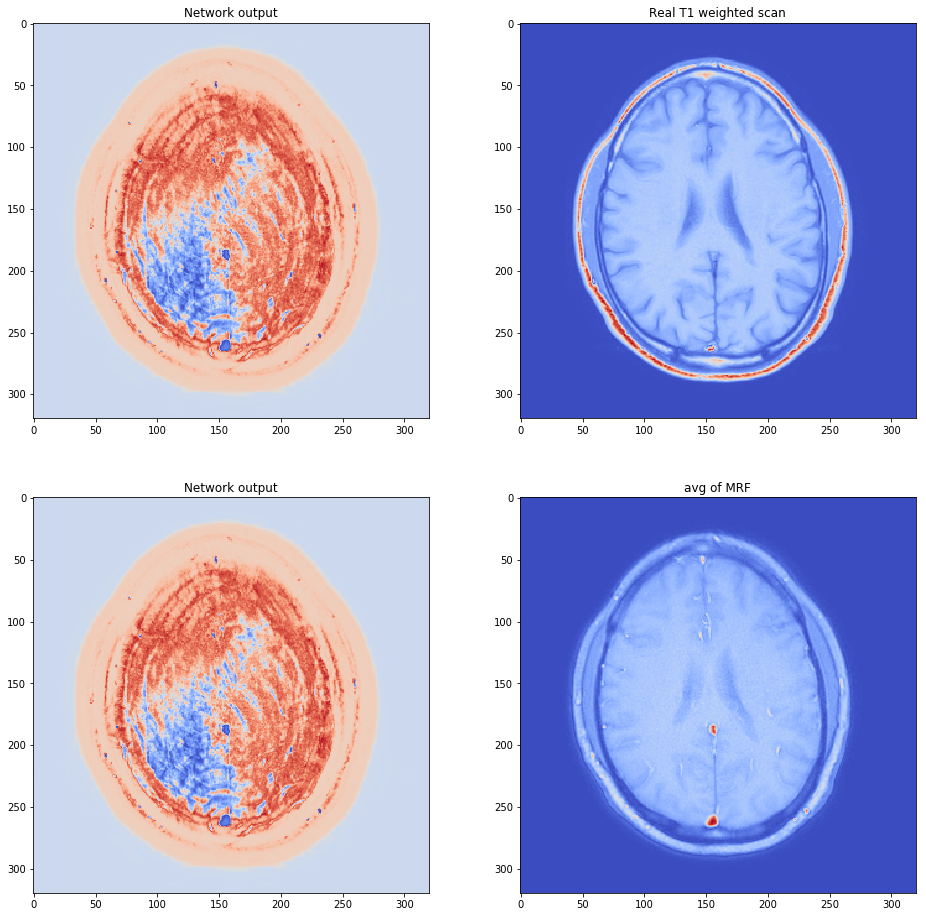

In [23]:
fig = plt.figure(figsize=(16,16))

plt.subplot(2, 2, 1)
plt.title("Network output")
plt.imshow(T1_array.reshape(320,320), cmap="coolwarm")

plt.subplot(2, 2, 2)
plt.title("Real T1 weighted scan")
plt.imshow(x[0], cmap="coolwarm")

plt.subplot(2, 2, 3)
plt.title("Network output")
plt.imshow(T1_array.reshape(320,320), cmap="coolwarm")

plt.subplot(2, 2, 4)
plt.title("avg of MRF")
plt.imshow(np.abs(np.mean(test_arr_complex, 0)), cmap="coolwarm")

plt.show()

In [12]:
test_arr_complex = np.load("/mikQNAP/augmented_data/MRF/MRF_norm_volunteer1_1.npy")
test_arr = np.load("MRF_magnitude/MRF_norm_volunteer1_1.npy")
x = np.load("/mikQNAP/augmented_data/T1w/T1_norm_volunteer1_1.npy")
print(test_arr.shape)

test1 = test_arr.reshape(500,-1).T
test1 = Variable(torch.from_numpy(test1).type(torch.FloatTensor))
test1 = test1.cuda().view(-1,500,1)

T1_array = np.array([])

slice_len = int(np.ceil(test1.size()[0]/16))
for i in range(16):
    T1 = regressor(test1[i*slice_len:(i+1)*slice_len])
    T1 = T1.data.cpu().numpy()
    T1_array = np.concatenate((T1_array, T1.flatten()))

print("mean: ", np.mean(T1_array))

(500, 320, 320)
mean:  0.1922175268185674


In [13]:
test_arr_complex = test_arr_complex[0:500] + 1j* test_arr_complex[500:1000]

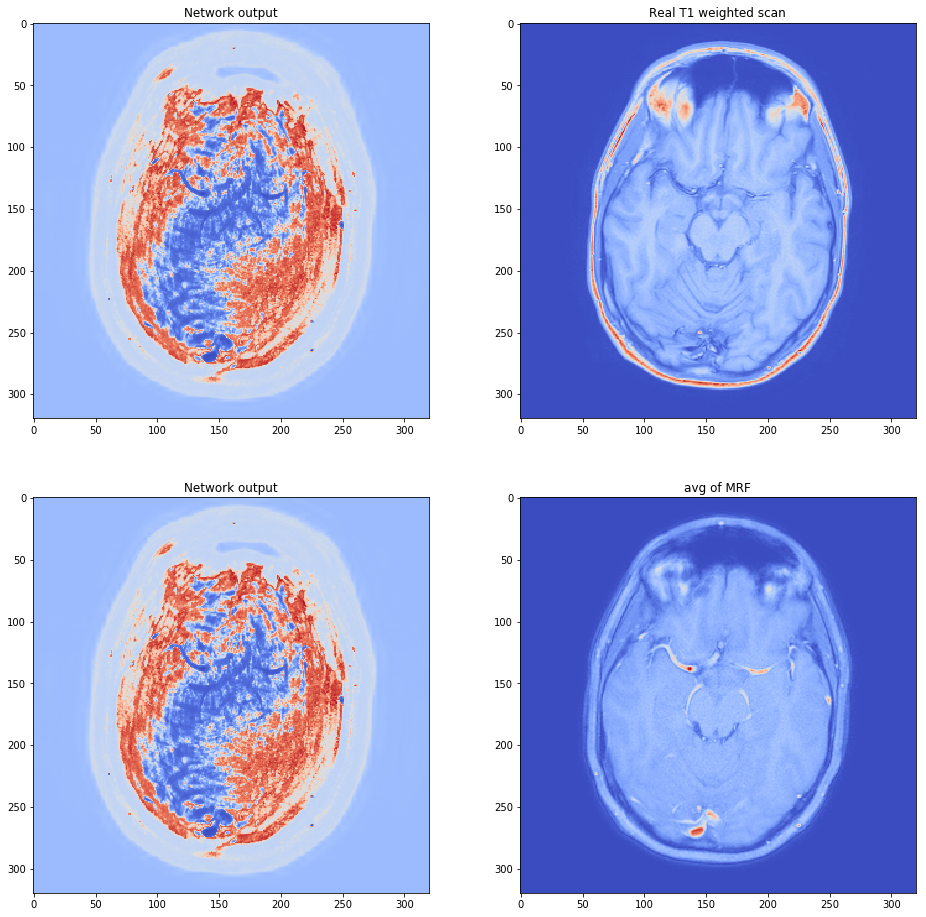

In [14]:
fig = plt.figure(figsize=(16,16))

plt.subplot(2, 2, 1)
plt.title("Network output")
plt.imshow(T1_array.reshape(320,320), cmap="coolwarm")

plt.subplot(2, 2, 2)
plt.title("Real T1 weighted scan")
plt.imshow(x[0], cmap="coolwarm")

plt.subplot(2, 2, 3)
plt.title("Network output")
plt.imshow(T1_array.reshape(320,320), cmap="coolwarm")

plt.subplot(2, 2, 4)
plt.title("avg of MRF")
plt.imshow(np.abs(np.mean(test_arr_complex, 0)), cmap="coolwarm")

plt.show()